# Assignment 3, Question 2

<b>Group [fill in group number]</b>
* <b> Student 1 </b> : Tommaso Bonomo (1511831)
* <b> Student 2 </b> : Mattia Molon (1511866)

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [2]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'Università', 'Deep Learning', 'Assignment 3', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [3]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/Università/Deep Learning/Assignment 3/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [4]:
def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')
  convnet.summary()

  # ...
  # rescale images
  preprocessed_images = (images / 255) * 2 - 1

  # retrieve model and compute codes
  input_layer = convnet.inputs
  output_layer = convnet.get_layer('Conv_1').output
  model = Model(inputs=input_layer, outputs=output_layer)
  print('Computing neural codes...')
  image_codes = model.predict(preprocessed_images, batch_size=100, verbose=1)

  # reshape codes 
  shape = (len(image_codes), -1)
  image_codes = image_codes.reshape(shape)
  # ...

  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape, image_codes.dtype)

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [0]:
# ...
captions = np.array(captions)

# max lemgth of captions
max_caption_length = max(map(len, captions.reshape(-1)))

# count words
word_dict = {}
for caption in captions:
  for line in caption:
    for word in line:
      if word in word_dict.keys():
        word_dict[word] += 1
      else:
        word_dict[word] = 1

# sort dictionaries by frequency
word_dict = {k:v for k,v in sorted(word_dict.items(), key=lambda item : item[1], reverse=True)}
word_to_idx = {'_': 0}
idx_to_word = {0: '_'}
for i,key in enumerate(word_dict.keys()):
  word_to_idx[key] = i+1
  idx_to_word[i+1] = key

# unique words
num_words = len(word_to_idx)

# ...

# Train/Validation/Test Split

In [0]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [7]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


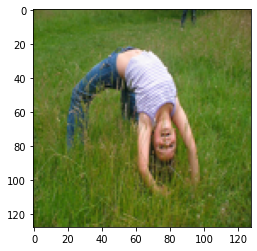

['a', 'girl', 'bends', 'over', 'backwards', 'in', 'the', 'tall', 'grass', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





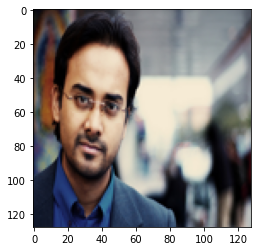

['a', 'closeup', 'of', 'a', 'man', 'in', 'glasses', 'looking', 'at', 'the', 'camera', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [8]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [9]:
from keras.utils import plot_model

def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,), name='img_input')
  caption_input = Input(shape=(max_caption_length - 1,), name='caption_input')

  # ...
  # embeddings
  emb_img = Dense(embedding_dim, name='emb_img')(image_input)
  emb_words = Embedding(num_words, embedding_dim, name='emb_words')(caption_input)

  # expand dimensions of img embedding to match words embeddings
  expand_emb_img = K.expand_dims(emb_img, axis=1) 

  # concatenate img and words (img must be first input of the sequence)
  concatenation = concatenate([expand_emb_img, emb_words], axis=1, name='concatenation')
  
  # LSTM layer
  LSTM_layer = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=True, name='LSTM')(concatenation)

  # output softmax to predict words
  output = Dense(num_words, activation='softmax', name='output')(LSTM_layer)
  # ...

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 20480)]      0                                            
__________________________________________________________________________________________________
emb_img (Dense)                 (None, 512)          10486272    img_input[0][0]                  
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 1, 512)]     0           emb_img[0][0]                    
____________________________________________________________________________________________

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

# ...
model.compile(optimizers.Adam(), 
              loss = 'sparse_categorical_crossentropy')
model.fit(x = [train_codes, train_y[:, :-1]], # model output at each step = p(S_t | img, S_0, S_1, ..., S_t-1)
          y = train_y,
          epochs = 100,
          batch_size = 100,
          callbacks = early_stopping_callback,
          validation_data = ([val_codes, val_y[:, :-1]], val_y))
# ...

model.save(os.path.join(base_path, 'model.h5'))

Epoch 1/100
305/305 [==============================] - 19s 62ms/step - loss: 1.6384 - val_loss: 1.3243
Epoch 2/100
305/305 [==============================] - 18s 61ms/step - loss: 1.2352 - val_loss: 1.1807
Epoch 3/100
305/305 [==============================] - 19s 61ms/step - loss: 1.1256 - val_loss: 1.1063
Epoch 4/100
305/305 [==============================] - 19s 61ms/step - loss: 1.0555 - val_loss: 1.0581
Epoch 5/100
305/305 [==============================] - 19s 61ms/step - loss: 1.0053 - val_loss: 1.0268
Epoch 6/100
305/305 [==============================] - 19s 61ms/step - loss: 0.9679 - val_loss: 1.0060
Epoch 7/100
305/305 [==============================] - 19s 61ms/step - loss: 0.9381 - val_loss: 0.9894
Epoch 8/100
305/305 [==============================] - 19s 61ms/step - loss: 0.9121 - val_loss: 0.9809
Epoch 9/100
305/305 [==============================] - 19s 61ms/step - loss: 0.8909 - val_loss: 0.9720
Epoch 10/100
305/305 [==============================] - 18s 60ms/step - l

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [11]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()

# ...
# Evaluating
print('Evaluating training set...')
train_loss = model.evaluate(x = [train_codes, train_y[:, :-1]],
                            y = train_y)
print('Evaluating validation set...')
val_loss = model.evaluate(x = [val_codes, val_y[:, :-1]],
                          y = val_y)

# Printing results
print(f'\nTrain loss = {train_loss}')
print(f'Valid loss = {val_loss}')
# ...

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 20480)]      0                                            
__________________________________________________________________________________________________
emb_img (Dense)                 (None, 512)          10486272    img_input[0][0]                  
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (None, 1, 512)       0           emb_img[0][0]                    
____________________________________________________________________________________________

# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [0]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):

  # input
  image_input = Input(shape=(code_length,))
  
  # ...
  # parameters
  predicted_caption = []

  # layers definition
  img_to_emb = Dense(embedding_dim, name='emb_img')
  LSTM_iterator = LSTM(lstm_dim, dropout=lstm_dropout, return_state=True, name='LSTM')
  embedder = Embedding(num_words, embedding_dim, name='emb_words')
  softmaxer = Dense(num_words, activation='softmax', name='softmaxer')

  # embedding image
  emb_img = img_to_emb(image_input)
  expanded_emb = K.expand_dims(emb_img, axis = 1)

  # first iteration LSTM 
  LSTM_output, state_h, state_c = LSTM_iterator(expanded_emb)
  previous_state = [state_h, state_c]
  softmax_output = softmaxer(LSTM_output)
  predicted_word = K.argmax(softmax_output, axis=1)
  predicted_caption.append(predicted_word)

  # LSTM cicle
  for i in range(max_caption_length - 1):
    # embed word
    emb_word = embedder(predicted_word)
    expanded_emb = K.expand_dims(emb_word, axis = 1)

    # LSTM iteration
    LSTM_output, state_h, state_c = LSTM_iterator(expanded_emb, initial_state=previous_state)
    previous_state = [state_h, state_c]
    softmax_output = softmaxer(LSTM_output)
    predicted_word = K.argmax(softmax_output, axis=1)
    predicted_caption.append(predicted_word)

  # stuck all outputs and complete network
  output = K.stack(predicted_caption, axis = 1)

  # finally, define model
  model = Model(inputs = image_input, outputs = output)
  
  # set layer weights
  model.get_layer('emb_img').set_weights(weights['emb_img'])
  model.get_layer('emb_words').set_weights(weights['emb_words'])
  model.get_layer('LSTM').set_weights(weights['LSTM'])
  model.get_layer('softmaxer').set_weights(weights['output'])
  # ...

  return model

# Get the weights from trained model, and put them in a list 'weights'.
# ...
layers = ['emb_img', 'emb_words', 'LSTM', 'output'] 
weights = {name : model.get_layer(name).get_weights() for name in layers}
# ...

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

In [15]:
decoder.outputs

[<tf.Tensor 'stack:0' shape=(None, 35) dtype=int64>]

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [16]:
# ...
# generate predictions
print(f'Predicting...') 
predictions = decoder.predict(test_codes, verbose=1, batch_size=100)

# transform indexes in words
captionize = lambda x: idx_to_word[x] 
pred_captions = np.vectorize(captionize)(predictions)
# ...

Predicting...
10/10 [==============================] - 1s 51ms/step


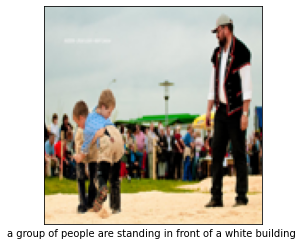

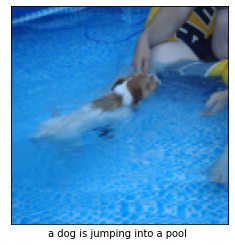

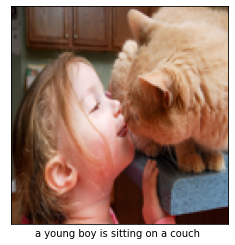

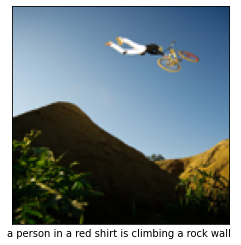

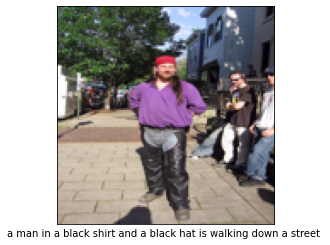

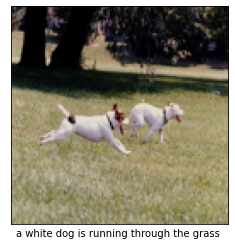

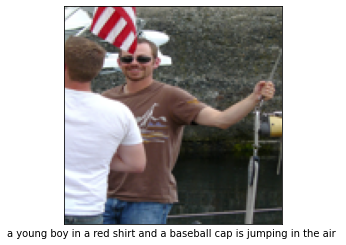

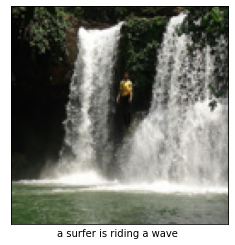

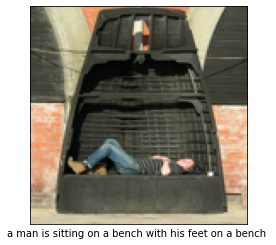

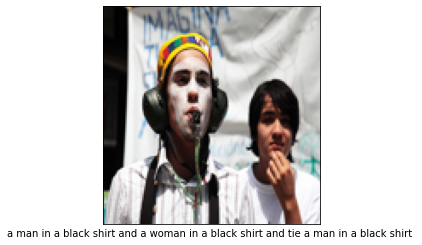

In [121]:
import matplotlib.pyplot as plt

np.random.seed(123)
random_idxs = np.random.randint(0, 1000, size = (10))

for i in random_idxs:
  caption = ' '.join(pred_captions[i]).split('_')[0]

  plt.imshow(test_images[i])
  plt.xticks([]), plt.yticks([])
  plt.xlabel(caption)
  plt.show()

In [118]:
import warnings
warnings.filterwarnings('ignore')

# n-grams BLUE score
gram1, gram2, gram3, gram4 = 0.0, 0.0, 0.0, 0.0
weights1, weights2, weights3 = tuple([1]), (0.5, 0.5), (0.33, 0.33, 0.33)

for i in range(len(test_captions)):
  gram1 += nltk.bleu(test_captions[i], np.delete(pred_captions[i], np.where(pred_captions[i] == '_')), weights=weights1)
  gram2 += nltk.bleu(test_captions[i], np.delete(pred_captions[i], np.where(pred_captions[i] == '_')), weights=weights2)
  gram3 += nltk.bleu(test_captions[i], np.delete(pred_captions[i], np.where(pred_captions[i] == '_')), weights=weights3)
  gram4 += nltk.bleu(test_captions[i], np.delete(pred_captions[i], np.where(pred_captions[i] == '_')))

# computing mean of the scores
gram1 /= len(test_captions)
gram2 /= len(test_captions)
gram3 /= len(test_captions)
gram4 /= len(test_captions)

# showing scores
print(f'1-gram BLUE score : {gram1}')
print(f'2-gram BLUE score : {gram2}')
print(f'3-gram BLUE score : {gram3}')
print(f'4-gram BLUE score : {gram4}')

1-gram BLUE score : 0.4987145901052212
2-gram BLUE score : 0.3988970248830321
3-gram BLUE score : 0.4297135398609971
4-gram BLUE score : 0.4838393884022894
